# Modeling and Evaluation Notebook

### Objectives

The client wants to predict whether a given cherry leaf is healthy or has powdery mildew.

### Inputs

### Outputs

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import itertools

2025-05-27 23:40:28.446866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
import json

# Set image shape and paths
img_shape = (256, 256)
batch_size = 32

train_path = "../inputs/split-leaves/train"
val_path = "../inputs/split-leaves/validation"
test_path = "../inputs/split-leaves/test"

# Data augmentation for training
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation and test (only rescaling)
test_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(
    train_path,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = test_aug.flow_from_directory(
    val_path,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_aug.flow_from_directory(
    test_path,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Save class indices for label decoding later
class_indices = train_data.class_indices

# save it as a JSON file for use in Streamlit
with open("../outputs/class_indices.json", "w") as f:
    json.dump(class_indices, f)

print("Class indices:", class_indices)

Found 4052 images belonging to 2 classes.
Found 1782 images belonging to 2 classes.
Found 980 images belonging to 2 classes.
Class indices: {'healthy': 0, 'powdery_mildew': 1}


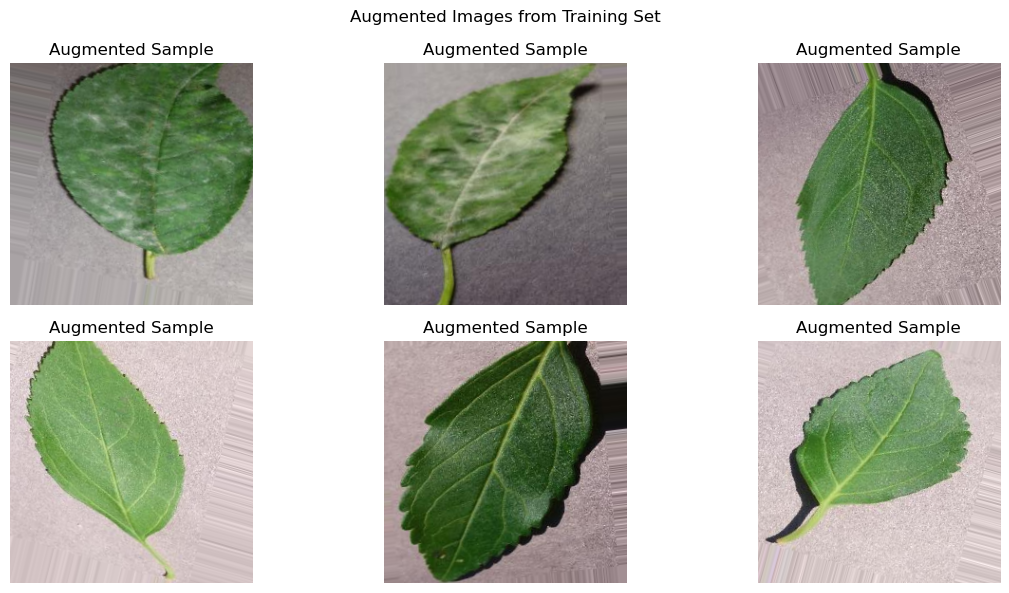

In [3]:
# Visualize augmented images from the training set
augmented_images, _ = next(train_data)

plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
    plt.title("Augmented Sample")
plt.suptitle("Augmented Images from Training Set")
plt.tight_layout()
plt.show()

### Model Training

In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Users/dappiah/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("mildew_model.h5", save_best_only=True)
]

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=callbacks
)

/Users/dappiah/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5389 - loss: 0.6536

127/127 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.5401 - loss: 0.6526 - val_accuracy: 0.9523 - val_loss: 0.2664
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9378 - loss: 0.1902

127/127 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9379 - loss: 0.1900 - val_accuracy: 0.9691 - val_loss: 0.1598
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9648 - loss: 0.1035

127/127 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9648 - loss: 0.1035 - val_accuracy: 0.9747 - val_loss: 0.1166
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9885 - loss: 0.0393 - val_accuracy: 0.9680 - val_loss: 0.1261
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.0308

127/127 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9914 - loss: 0.0308 - val_accuracy: 0.9776 - val_loss: 0.0967
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9940 - loss: 0.0166 

127/127 ━━━━━━━━━━━━━━━━━━━━ 2035s 16s/step - accuracy: 0.9939 - loss: 0.0166 - val_accuracy: 0.9781 - val_loss: 0.0874
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9944 - loss: 0.0177

127/127 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9944 - loss: 0.0177 - val_accuracy: 0.9860 - val_loss: 0.0497
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2172s 17s/step - accuracy: 0.9964 - loss: 0.0102 - val_accuracy: 0.9450 - val_loss: 0.1714
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2310s 18s/step - accuracy: 0.9796 - loss: 0.0477 - val_accuracy: 0.9848 - val_loss: 0.0716
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9953 - loss: 0.0134 - val_accuracy: 0.9837 - val_loss: 0.0671
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9929 - loss: 0.0207

127/127 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9929 - loss: 0.0207 - val_accuracy: 0.9938 - val_loss: 0.0173
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9743 - loss: 0.1033 - val_accuracy: 0.9848 - val_loss: 0.0840
Epoch 13/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9941 - loss: 0.0207 - val_accuracy: 0.9843 - val_loss: 0.0555
Epoch 14/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9959 - loss: 0.0157 - val_accuracy: 0.9854 - val_loss: 0.0618
Epoch 15/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9920 - loss: 0.0163 - val_accuracy: 0.9837 - val_loss: 0.0958
Epoch 16/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9976 - loss: 0.0083 - val_accuracy: 0.9686 - val_loss: 0.1015


### Model Performance

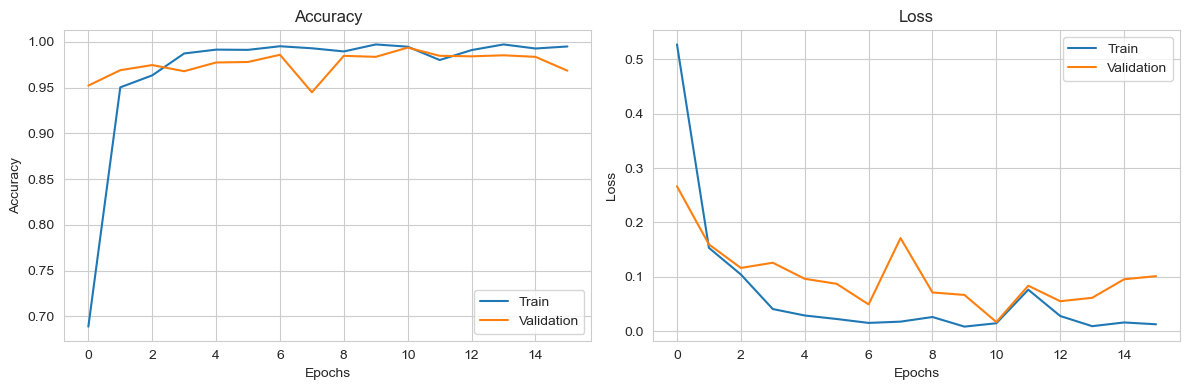

In [11]:
# Plot training & validation accuracy/loss
from pathlib import Path

# Ensure output folder exists
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)
sns.set_style("whitegrid")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(output_dir / "model_training_accuracy.png", bbox_inches='tight', dpi=150)



plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(output_dir / "model_training_losses.png", bbox_inches='tight', dpi=150)


plt.tight_layout()
plt.show()

### Predict on New Data

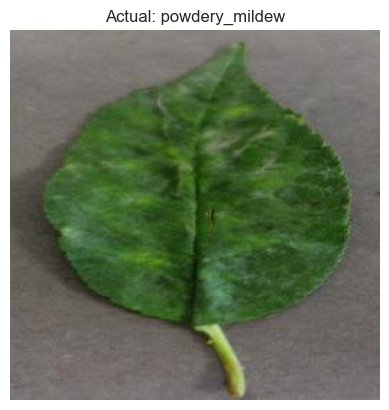

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: powdery_mildew | Confidence: 1.00
--------------------------------------------------


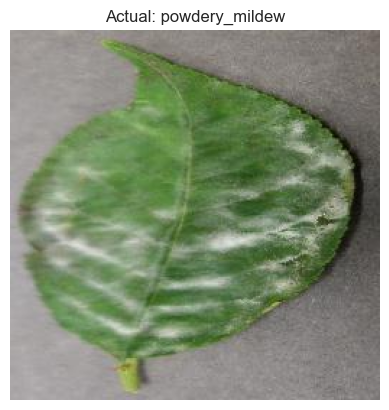

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: powdery_mildew | Confidence: 1.00
--------------------------------------------------


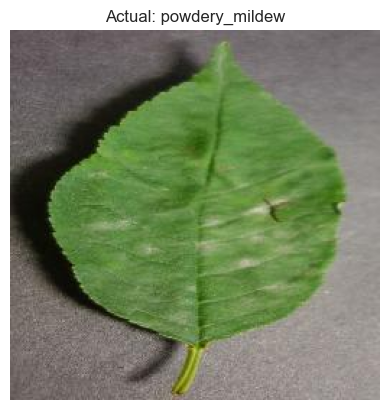

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: powdery_mildew | Confidence: 1.00
--------------------------------------------------


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Setup
test_path = "../inputs/split-leaves/test"
labels = ["healthy", "powdery_mildew"]
num_preds = 3  # or change to 5 if you prefer

for i in range(num_preds):
    label = random.choice(labels)
    img_list = os.listdir(os.path.join(test_path, label))
    pointer = random.randint(0, len(img_list) - 1)

    img_path = os.path.join(test_path, label, img_list[pointer])
    pil_image = image.load_img(img_path, target_size=(256, 256), color_mode='rgb')

    # Display the image
    plt.imshow(pil_image)
    plt.axis("off")
    plt.title(f"Actual: {label}")
    plt.show()

    # Preprocess and predict
    img_array = image.img_to_array(pil_image)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred_proba = model.predict(img_array)[0, 0]
    pred_class = "powdery_mildew" if pred_proba > 0.5 else "healthy"
    confidence = pred_proba if pred_proba > 0.5 else 1 - pred_proba

    print(f"Predicted: {pred_class} | Confidence: {confidence:.2f}")
    print("-" * 50)
